In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data
License(s): CC0-1.0
100% 237M/238M [00:02<00:00, 102MB/s]
100% 238M/238M [00:02<00:00, 105MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diabetic-retinopathy-224x224-2019-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image

In [ ]:
df=pd.read_csv("/content/train.csv")

In [ ]:
df

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


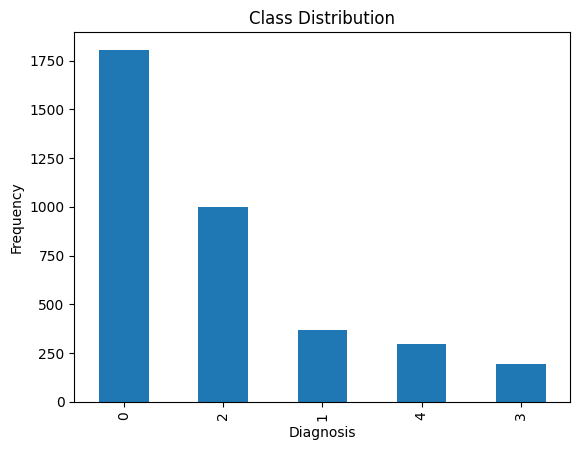

In [ ]:
df['diagnosis'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/content/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['type'])
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = Path('/content/DL_Diabetic_Retinopathy')
train_dir = base_dir / 'train'
val_dir = base_dir / 'val'
test_dir = base_dir / 'test'

# Create directories
for directory in [base_dir, train_dir, val_dir, test_dir]:
    directory.mkdir(parents=True, exist_ok=True)


In [ ]:
# Copy images to respective working directory
src_dir = Path('/content/colored_images')
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = src_dir / diagnosis / id_code
    dstfile = train_dir / binary_diagnosis / id_code
    dstfile.parent.mkdir(parents=True, exist_ok=True)  # Ensure parent directory exists
    with open(srcfile, 'rb') as src, open(dstfile, 'wb') as dst:
        dst.write(src.read())

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = src_dir / diagnosis / id_code
    dstfile = val_dir / binary_diagnosis / id_code
    dstfile.parent.mkdir(parents=True, exist_ok=True)  # Ensure parent directory exists
    with open(srcfile, 'rb') as src, open(dstfile, 'wb') as dst:
        dst.write(src.read())

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = src_dir / diagnosis / id_code
    dstfile = test_dir / binary_diagnosis / id_code
    dstfile.parent.mkdir(parents=True, exist_ok=True)  # Ensure parent directory exists
    with open(srcfile, 'rb') as src, open(dstfile, 'wb') as dst:
        dst.write(src.read())

In [ ]:
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, target_size=(224, 224), batch_size=32)
val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(224, 224), batch_size=32)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(224, 224), batch_size=32)


Found 3625 images belonging to 2 classes.
Found 1752 images belonging to 2 classes.
Found 1744 images belonging to 2 classes.


In [ ]:
# Building the model

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 51, 51, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         640,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649,938 (2.48 MB)

 Trainable params: 649,826 (2.48 MB)

 Non-trainable params: 112 (448.00 B)

In [ ]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=val_batches)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.8621 - loss: 0.3268 - val_accuracy: 0.5057 - val_loss: 0.7348
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9328 - loss: 0.1945 - val_accuracy: 0.5057 - val_loss: 0.9338
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9459 - loss: 0.1620 - val_accuracy: 0.5879 - val_loss: 0.5526
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9514 - loss: 0.1371 - val_accuracy: 0.9081 - val_loss: 0.2778
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9494 - loss: 0.1402 - val_accuracy: 0.9561 - val_loss: 0.1285
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9689 - loss: 0.0930 - val_accuracy: 0.9652 - val_loss: 0.1334
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9579 - loss: 0.1143 - val_accuracy: 0.9795 - val_loss: 0.0655
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9751 - loss: 0.0758 - val_accu

In [ ]:
model.save('my_model.keras')

In [ ]:
from google.colab import files
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc)

55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.9933 - loss: 0.0396
Accuracy:  0.9896789193153381


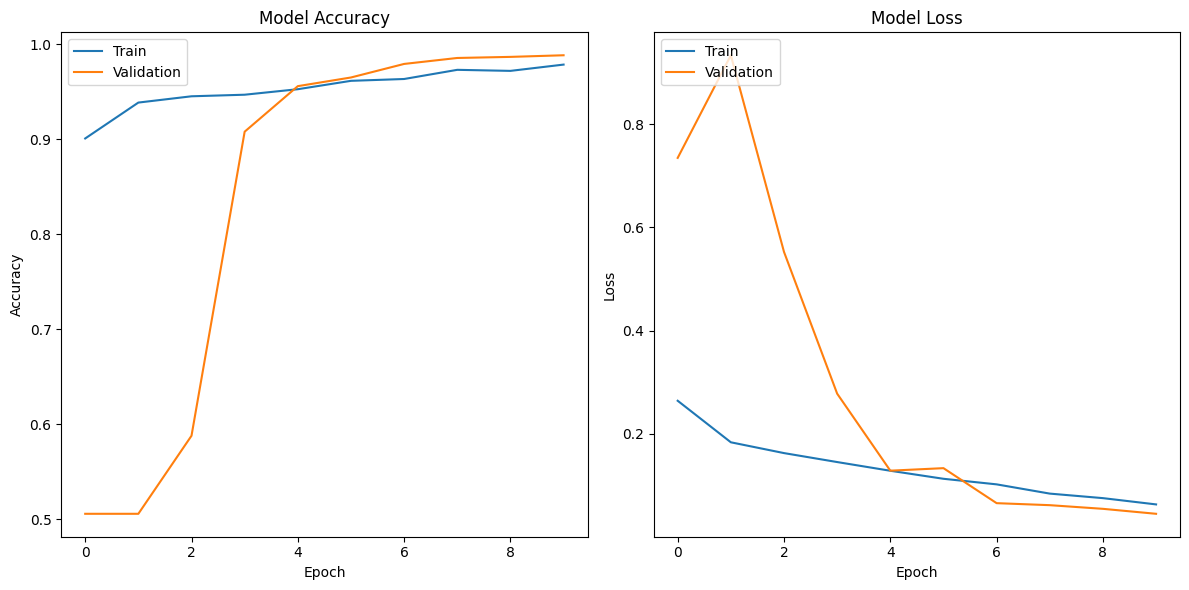

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 460ms/step


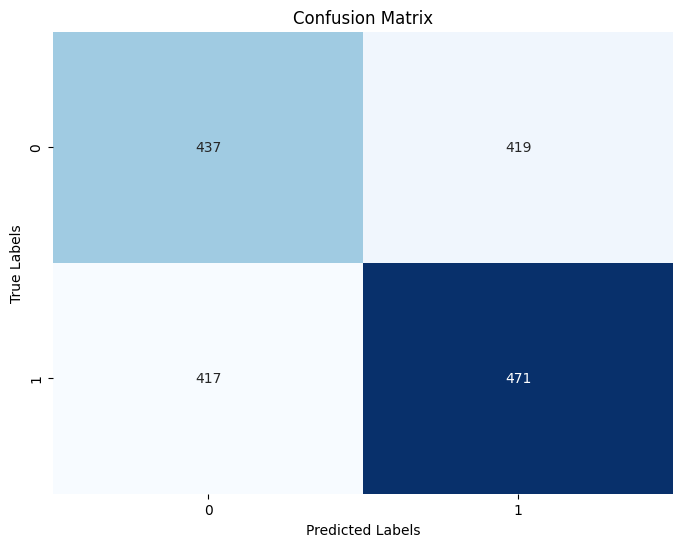

In [ ]:
# Make predictions
predictions = model.predict(test_batches)
y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Class indices:", train_batches.class_indices)

Class indices: {'DR': 0, 'No_DR': 1}


In [ ]:
# Load the image you want to test
test_image_path = "/content/DL_Diabetic_Retinopathy/test/DR/000c1434d8d7.png"
test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)

# Preprocess the image
preprocessed_test_image = test_image_array / 255.0  # Normalize pixel values

# Use the trained model to make predictions
predictions = model.predict(preprocessed_test_image)
predicted_class_index = np.argmax(predictions)

# Reverse the class indices dictionary
class_labels = {v: k for k, v in train_batches.class_indices.items()}

# Get the predicted class label using the reversed dictionary
predicted_class = class_labels[predicted_class_index]

# Interpret the predictions
print("Predicted class:", predicted_class)
print("Predicted probabilities:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted class: DR
Predicted probabilities: [[1.0000000e+00 1.7699895e-09]]


In [ ]:
# Load the image you want to test
test_image_path = "/content/DL_Diabetic_Retinopathy/test/No_DR/0b8bdec9d869.png"
test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)

# Preprocess the image
preprocessed_test_image = test_image_array / 255.0  # Normalize pixel values

# Use the trained model to make predictions
predictions = model.predict(preprocessed_test_image)
predicted_class_index = np.argmax(predictions)

# Reverse the class indices dictionary
class_labels = {v: k for k, v in train_batches.class_indices.items()}

# Get the predicted class label using the reversed dictionary
predicted_class = class_labels[predicted_class_index]

# Interpret the predictions
print("Predicted class:", predicted_class)
print("Predicted probabilities:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: No_DR
Predicted probabilities: [[1.8780061e-23 1.0000000e+00]]
